In [1]:
!pip install moviepy

     ---------------------------------------- 0.0/388.3 kB ? eta -:--:--
     --- ----------------------------------- 30.7/388.3 kB 1.3 MB/s eta 0:00:01
     --- --------------------------------- 41.0/388.3 kB 393.8 kB/s eta 0:00:01
     --------- -------------------------- 102.4/388.3 kB 737.3 kB/s eta 0:00:01
     ----------- ------------------------ 122.9/388.3 kB 654.9 kB/s eta 0:00:01
     ----------------------- -------------- 235.5/388.3 kB 1.0 MB/s eta 0:00:01
     ----------------------- -------------- 235.5/388.3 kB 1.0 MB/s eta 0:00:01
     ----------------------- -------------- 235.5/388.3 kB 1.0 MB/s eta 0:00:01
     ----------------------------- ------ 317.4/388.3 kB 893.0 kB/s eta 0:00:01
     ----------------------------- ------ 317.4/388.3 kB 893.0 kB/s eta 0:00:01
     ----------------------------- ------ 317.4/388.3 kB 893.0 kB/s eta 0:00:01
     ----------------------------- ------ 317.4/388.3 kB 893.0 kB/s eta 0:00:01
     ----------------------------- ------ 317.4


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import gymnasium
import stable_baselines3
from gymnasium.wrappers import RecordVideo
from stable_baselines3 import DQN
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecFrameStack, VecVideoRecorder
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import VecTransposeImage
from stable_baselines3.common.atari_wrappers import WarpFrame

import os
import numpy
import platform
import matplotlib
import matplotlib.pyplot
import torch
from importlib.metadata import version

In [2]:
print(f"Python Version: {platform.python_version()}")
print(f"Torch Version: {version('torch')}")
print(f"Is Cuda Available: {torch.cuda.is_available()}")
print(f"Cuda Version: {torch.version.cuda}")
print(f"Gymnasium Version: {version('gymnasium')}")
print(f"Numpy Version: {version('numpy')}")
print(f"Scipy Version: {version('scipy')}")
print(f"Swig Version: {version('swig')}")
print(f"Stable Baselines3 Version: {version('stable_baselines3')}")
print(f"IPython Version: {version('ipython')}")

Python Version: 3.9.0
Torch Version: 2.5.1+cu124
Is Cuda Available: True
Cuda Version: 12.4
Gymnasium Version: 0.29.1
Numpy Version: 2.0.2
Scipy Version: 1.13.1
Swig Version: 4.2.1.post0
Stable Baselines3 Version: 2.3.2
IPython Version: 7.34.0


In [3]:
gymnasium.register(
    id='MultiCarRacing-v2',
    entry_point='merger:MultiCarRacing',
    max_episode_steps=1000,
    reward_threshold=900
)

In [4]:
env = gymnasium.make('MultiCarRacing-v2', continuous=False, num_agents=1)
print("Observation Space Size: ", env.observation_space)
print("Action Space Size: ", env.action_space)
env.close()

Observation Space Size:  Box(0, 255, (96, 96, 3), uint8)
Action Space Size:  Discrete(5)


In [5]:
env_str = "MultiCarRacing-v2"
log_dir = "./logs/{}".format(env_str)
env_kwargs_dict={"continuous": False, 
                 "num_agents": 1}
gray_scale = True

# If gray_scale True, convert obs to gray scale 84 x 84 image
wrapper_class = WarpFrame if gray_scale else None

In [6]:
# Create Training CarRacing environment
env = make_vec_env(env_str,
                   n_envs=1,
                   env_kwargs=env_kwargs_dict,
                   wrapper_class=wrapper_class)
env = VecFrameStack(env, n_stack=4)
env = VecTransposeImage(env)

# Create Evaluation CarRacing environment
env_val = make_vec_env(env_str,
                       n_envs=1,
                       env_kwargs=env_kwargs_dict,
                       wrapper_class=wrapper_class)
env_val = VecFrameStack(env_val, n_stack=4)
env_val = VecTransposeImage(env_val)

# Create Evaluation Callback
# eval_freq - can cause learning instability if set to low
eval_callback = EvalCallback(env_val,
                             best_model_save_path=log_dir,
                             log_path=log_dir,
                             eval_freq=25_000,
                             render=False,
                             n_eval_episodes=20)

# Initialize DQN
# buffer_size - encourages exploration of other actions
model = DQN('CnnPolicy',
            env,
            verbose=0,
            buffer_size=150_000)

# Train the model
model.learn(total_timesteps=750_000,
            progress_bar=True,
            callback=eval_callback)

# Save the model
model.save(os.path.join(log_dir, "dqn_car_racing"))

mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=20)
print(f"Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

env.close()
env_val.close()

D:\Programming\IUT\rl-carracing\.venv\lib\site-packages\gymnasium\utils\passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


error: OpenCV(4.10.0) d:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function '__cdecl cv::impl::`anonymous-namespace'::CvtHelper<struct cv::impl::`anonymous namespace'::Set<3,4,-1>,struct cv::impl::A0x46dff480::Set<1,-1,-1>,struct cv::impl::A0x46dff480::Set<0,2,5>,4>::CvtHelper(const class cv::_InputArray &,const class cv::_OutputArray &,int)'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1


In [6]:
# Create Evaluation CarRacing environment
env = make_vec_env(env_str,
                   n_envs=1,
                   seed=0,
                   env_kwargs=env_kwargs_dict,
                   wrapper_class=wrapper_class)
env = VecFrameStack(env, n_stack=4)
env = VecTransposeImage(env)

# Load the best model
best_model_path = os.path.join(log_dir, "best_model.zip")
best_model = DQN.load(best_model_path, env=env)

mean_reward, std_reward = evaluate_policy(best_model, env, n_eval_episodes=20)
print(f"Best Model - Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

# Record video of the best model playing CarRacing
env = VecVideoRecorder(env, "./videos/",
                       video_length=10000,
                       record_video_trigger=lambda x: x == 0,
                       name_prefix="best_model_car_racing_dqn")

obs = env.reset()
for _ in range(10000):
    action, _states = best_model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    env.render()
    if dones:
        break

env.close()

Best Model - Mean reward: -63.97 +/- 40.15
Moviepy - Building video D:\Programming\IUT\rl-carracing\videos\best_model_car_racing_dqn-step-0-to-step-10000.mp4.
Moviepy - Writing video D:\Programming\IUT\rl-carracing\videos\best_model_car_racing_dqn-step-0-to-step-10000.mp4



Moviepy - Done !
Moviepy - video ready D:\Programming\IUT\rl-carracing\videos\best_model_car_racing_dqn-step-0-to-step-10000.mp4


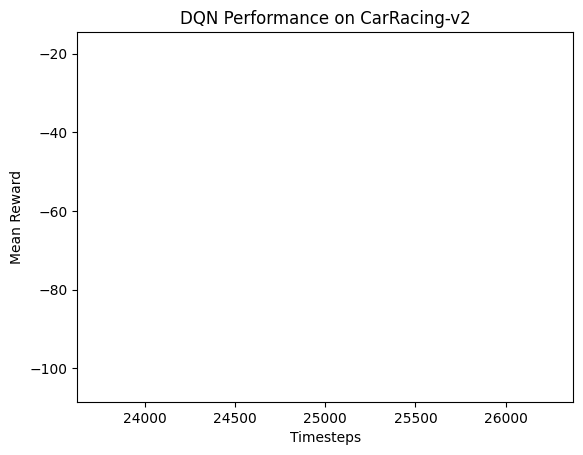

In [8]:
# Load the evaluations.npz file
data = numpy.load(os.path.join(log_dir, "evaluations.npz"))

# Extract the relevant data
timesteps = data['timesteps']
results = data['results']

# Calculate the mean and standard deviation of the results
mean_results = numpy.mean(results, axis=1)
std_results = numpy.std(results, axis=1)

# Plot the results
matplotlib.pyplot.figure()
matplotlib.pyplot.plot(timesteps, mean_results)
matplotlib.pyplot.fill_between(timesteps,
                               mean_results - std_results,
                               mean_results + std_results,
                               alpha=0.3)

matplotlib.pyplot.xlabel("Timesteps")
matplotlib.pyplot.ylabel("Mean Reward")
matplotlib.pyplot.title(f"DQN Performance on {env_str}")
matplotlib.pyplot.show()